In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

## Aleatoric homoskedastic model

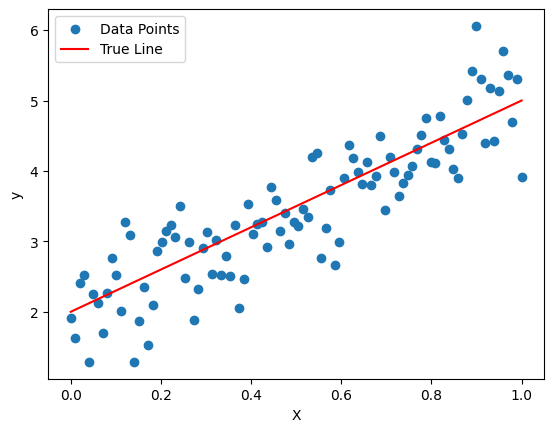

In [2]:
# Generate the dataset
slope = 3
intercept = 2
N = 100
X = np.linspace(0, 1, N)
true_sigma = 0.5
noise = np.random.normal(0, true_sigma, N)
y = slope * X + intercept + noise
plt.scatter(X, y)
plt.plot(X, slope * X + intercept, 'r')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(['Data Points', 'True Line'])
plt.show()

In [3]:
# We have three parameters: slope, intercept, and sigma(std of noise)
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Define the forward pass
def forward(X, slope, intercept, sigma):
    return slope * X + intercept + torch.distributions.Normal(0, sigma).sample(X.shape)

# define the loss function
def nll(theta, sigma,  X, y):   #theta = [intercept, slope]
    mu = theta[0] + theta[1] * X
    dist = torch.distributions.normal.Normal(mu, sigma)
    return y.shape[0]*torch.log(sigma) + (0.5) * torch.sum( (y - mu)**2 ) / (sigma**2)


# initialize the parameters
theta0 = torch.tensor(0.0, requires_grad=True)
theta1 = torch.tensor(0.0, requires_grad=True)
sigma = torch.tensor(0.1, requires_grad=True)

# Define optimizer
optimizer = optim.Adam([theta0, theta1, sigma], lr=0.01)
num_epochs = 1000

# Gradient descent
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = nll([theta0, theta1], sigma, X, y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch {}, Loss {}'.format(epoch, loss.item()))

print('Final parameters: slope {}, intercept {}, sigma {}'.format(theta1.item(), theta0.item(), sigma.item()))
print("--------------------------------------------")
# Print the final parameters
final_params = {"intercept": theta0.item(), "slope": theta1.item(), "sigma": sigma.item()}
true_params = {"intercept": intercept, "slope": slope, "sigma": true_sigma }

df = pd.DataFrame([final_params, true_params], index=['Learnt', 'True'])
print(df)

Epoch 0, Loss 64305.22265625
Epoch 100, Loss 2942.38916015625
Epoch 200, Loss 1520.5653076171875
Epoch 300, Loss 911.0845336914062
Epoch 400, Loss 578.9489135742188
Epoch 500, Loss 376.2941589355469
Epoch 600, Loss 245.10855102539062
Epoch 700, Loss 157.60147094726562
Epoch 800, Loss 98.54637145996094
Epoch 900, Loss 58.739253997802734
Final parameters: slope 2.01743745803833, intercept 1.94204580783844, sigma 0.5802361369132996
--------------------------------------------
        intercept     slope     sigma
Learnt   1.942046  2.017437  0.580236
True     2.000000  3.000000  0.500000


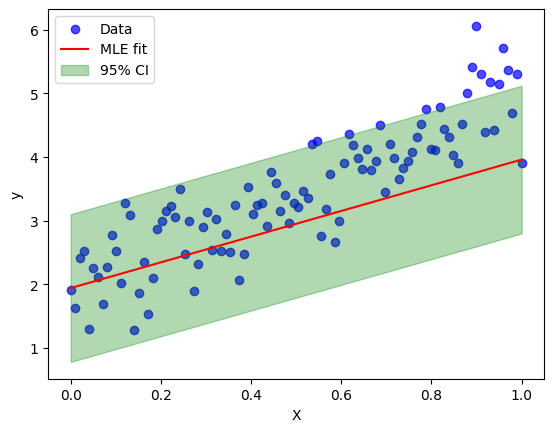

In [4]:
# Plot the final line + confidence interval
plt.scatter(X, y, label='Data', color='blue', alpha=0.7)
plt.plot(X, theta1.item() * X + theta0.item(), label='MLE fit', color='red')
plt.fill_between(X, theta1.item() * X + theta0.item() + 2 * sigma.item(), theta1.item() * X + theta0.item() - 2 * sigma.item(), 
                 label='95% CI', color='green', alpha=0.3)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## Aleatoric Heteroskedastic model

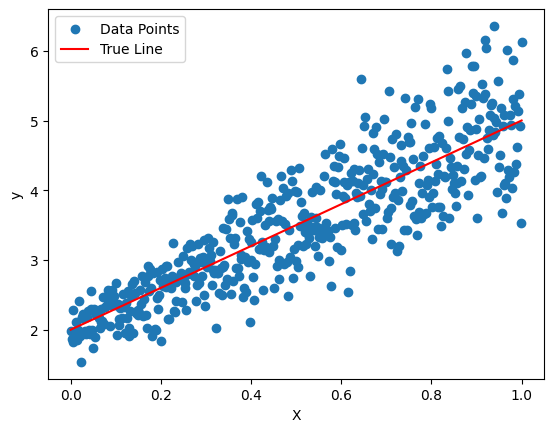

In [5]:
# Generate the dataset
slope = 3
intercept = 2
true_sigma = 0.5 + 0.1 * X.squeeze()  # Varying standard deviation
N = 500
X = np.linspace(0, 1, N)
def noise(x):
    # Define a function that determines the true standard deviation
    std = 0.2 + 0.5 * x.squeeze()
    return np.random.normal(0, std, x.shape)

y = slope * X + intercept + noise(X)
plt.scatter(X, y)
plt.plot(X, slope * X + intercept, 'r')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(['Data Points', 'True Line'])
plt.show()

In [6]:
# We have four parameters: slope, intercept, slope of sigma and intercept of sigma
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# define the loss function
def nll(theta, sigma,  X, y):   #theta = [intercept, slope] , sigma = [intercept_std, slope_std]
    def noise_gen(x):
    # Define a function that determines the standard deviation
        std = sigma[0] + sigma[1] * x.squeeze()
        return np.random.normal(0, std.detach().numpy(), x.shape)
    mu = theta[0] + theta[1] * X + torch.tensor(noise_gen(X), dtype=torch.float32, requires_grad=True)
    std = sigma[0] + sigma[1]* X.squeeze()
    return torch.sum(torch.log(std) + (0.5 * (y - mu) ** 2) / (std ** 2))

# initialize the parameters
theta0 = torch.tensor(0.0, requires_grad=True)
theta1 = torch.tensor(1.0, requires_grad=True)
sigma0 = torch.tensor(0.01, requires_grad=True)
sigma1 = torch.tensor(0.1, requires_grad=True)

# Define optimizer
optimizer = optim.Adam([theta0, theta1, sigma0, sigma1], lr=0.01)
num_epochs = 2000

# Gradient descent
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = nll([theta0, theta1], [sigma0, sigma1], X, y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch {}, Loss {}'.format(epoch, loss.item()))

# Print the final parameters
print('Final parameters: slope {}, intercept {}, sigma_slope {}, sigma_intercept {}'.format(theta1.item(), theta0.item(), 
                                                                  sigma1.item(), sigma0.item()))
print("--------------------------------------------")
final_params = {"intercept": theta0.item(), "slope": theta1.item(), "sigma_intercept": sigma0.item(), "sigma_slope": sigma1.item()}
true_params = {"intercept": intercept, "slope": slope, "sigma_intercept": 0.2, "sigma_slope": 0.5}
df = pd.DataFrame([final_params, true_params], index=['Learnt', 'True'])
print(df)

Epoch 0, Loss 1272118.5
Epoch 100, Loss 25987.876953125
Epoch 200, Loss 14825.5947265625
Epoch 300, Loss 9466.064453125
Epoch 400, Loss 6332.84765625
Epoch 500, Loss 4312.162109375
Epoch 600, Loss 2967.04248046875
Epoch 700, Loss 2118.271484375
Epoch 800, Loss 1461.87353515625
Epoch 900, Loss 1087.0224609375
Epoch 1000, Loss 707.8825073242188
Epoch 1100, Loss 579.2169189453125
Epoch 1200, Loss 373.03033447265625
Epoch 1300, Loss 307.36517333984375
Epoch 1400, Loss 214.4083251953125
Epoch 1500, Loss 198.05569458007812
Epoch 1600, Loss 141.50674438476562
Epoch 1700, Loss 126.92947387695312
Epoch 1800, Loss 59.053428649902344
Epoch 1900, Loss 120.88328552246094
Final parameters: slope 3.372051477432251, intercept 1.8027478456497192, sigma_slope 0.4797327220439911, sigma_intercept 0.20442096889019012
--------------------------------------------
        intercept     slope  sigma_intercept  sigma_slope
Learnt   1.802748  3.372051         0.204421     0.479733
True     2.000000  3.000000    

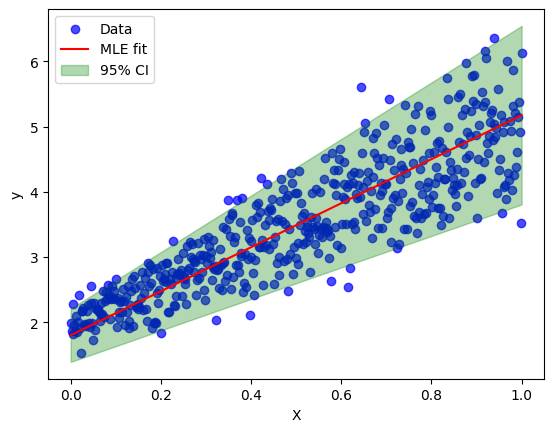

In [7]:
# Plot the final line + confidence interval
plt.scatter(X, y, label='Data', color='blue', alpha=0.7)
plt.plot(X, theta1.item() * X + theta0.item(), label='MLE fit', color='red')
plt.fill_between(X, theta1.item() * X + theta0.item() + 2 * sigma1.item()*X + 2 * sigma0.item(), theta1.item() * X + theta0.item() - 2 * sigma1.item()*X - 2 * sigma0.item(),
                    label='95% CI', color='green', alpha=0.3)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## Using NN: Aleatoric Homoskedastic model

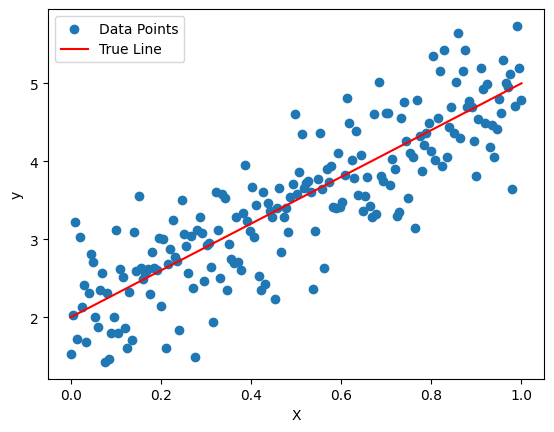

In [8]:
# Using neural network
# create the dataset for homoSk model
slope = 3
intercept = 2
true_sigma = 0.5
N = 200
X = np.linspace(0, 1, N)
noise = torch.distributions.Normal(0, true_sigma).sample(X.shape).detach().numpy()
y = slope * X + intercept + noise
plt.scatter(X, y)
plt.plot(X, slope * X + intercept, 'r')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(['Data Points', 'True Line'])
plt.show()

In [9]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Create the neural network
torch.manual_seed(56)
class AleatoricLR_homoSK(nn.Module):
    def __init__(self):
        super(AleatoricLR_homoSK, self).__init__()
        self.fc1 = nn.Linear(in_features=N, out_features=64)  
        self.fc2 = nn.Linear(64, 32)
        self.fc3= nn.Linear(32, 3) 

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        theta0 = x[0]
        theta1 = x[1]
        std = x[2]
        return theta0, theta1, std
        

model = AleatoricLR_homoSK()

# define the loss function
def nll(theta, sigma,  X, y):   #theta = [intercept, slope]
    mu = theta[0] + theta[1] * X
    # dist = torch.distributions.normal.Normal(mu, sigma)
    return y.shape[0]*torch.log(sigma) + (0.5) * torch.sum( (y - mu)**2 ) / (sigma**2)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    theta0, theta1, std = model(X)
    loss = torch.mean(nll([theta0, theta1], std, X, y))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

# Extract learned parameters
theta0, theta1, std = model(X)

print('Final parameters: slope {}, intercept {}, sigma {}'.format(theta1.item(), theta0.item(), std.item()))
print("--------------------------------------------")
final_params = {"intercept": theta0.item(), "slope": theta1.item(), "sigma": std.item()}
true_params = {"intercept": intercept, "slope": slope, "sigma": true_sigma }
df = pd.DataFrame([final_params, true_params], index=['Learnt', 'True'])
print(df)


Epoch [100/1000], Loss: 417.3017578125
Epoch [200/1000], Loss: 0.5336265563964844
Epoch [300/1000], Loss: -35.621742248535156
Epoch [400/1000], Loss: -35.792625427246094
Epoch [500/1000], Loss: -35.79267120361328
Epoch [600/1000], Loss: -35.79267120361328
Epoch [700/1000], Loss: -35.79267883300781
Epoch [800/1000], Loss: -35.79267883300781
Epoch [900/1000], Loss: -35.79267883300781
Epoch [1000/1000], Loss: -35.79267120361328
Final parameters: slope 2.9240689277648926, intercept 2.0089638233184814, sigma 0.5071427226066589
--------------------------------------------
        intercept     slope     sigma
Learnt   2.008964  2.924069  0.507143
True     2.000000  3.000000  0.500000


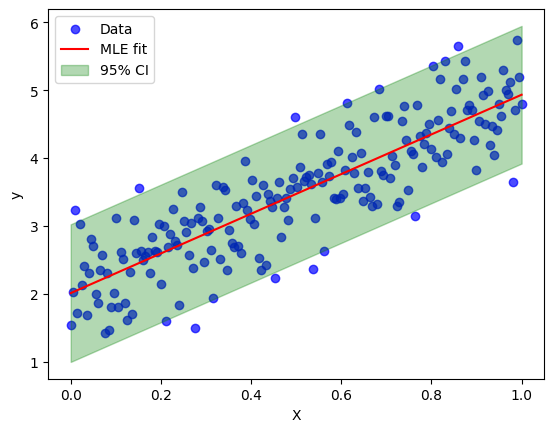

In [10]:
# Plot the final line + confidence interval
plt.scatter(X, y, label='Data', color='blue', alpha=0.7)
plt.plot(X, theta1.item() * X + theta0.item(), label='MLE fit', color='red')
plt.fill_between(X, theta1.item() * X + theta0.item() + 2 * std.item(), theta1.item() * X + theta0.item() - 2 * std.item(),
                    label='95% CI', color='green', alpha=0.3)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

0      0.174596
1      0.503648
2      0.990455
3      0.255183
4      0.971157
         ...   
195    0.007713
196    0.362188
197    0.949597
198    0.707995
199    0.389630
Name: perc, Length: 200, dtype: float64
0     -0.936160
1      0.009144
2      2.343784
3     -0.658266
4      1.898081
         ...   
195   -2.422222
196   -0.352616
197    1.640963
198    0.547536
199   -0.280283
Name: z, Length: 200, dtype: float64


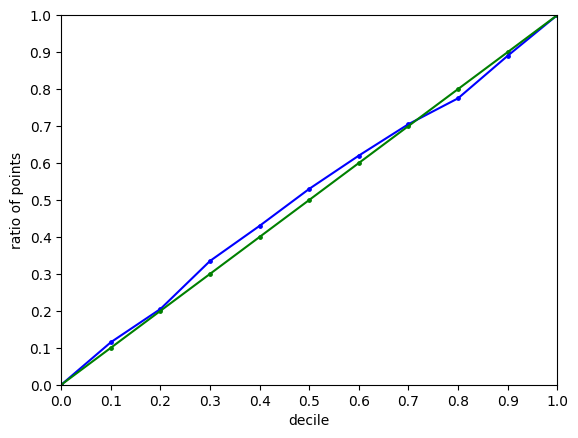

In [12]:
import scipy.stats as st

def reliability_diagram(mean, sigma, Y, color="blue", label="Model", marker_size=6):
    fig, ax = plt.subplots()
    df = pd.DataFrame()
    df["mean"] = mean
    df["sigma"] = sigma
    df["Y"] = Y
    df["z"] = (df["Y"] - df["mean"]) / df["sigma"]
    df["perc"] = st.norm.cdf(df["z"])
    print(df["perc"])
    print(df["z"])
    k = np.arange(0, 1.1, 0.1)
    counts = []
    df2 = pd.DataFrame()
    df2["Interval"] = k
    df2["Ideal"] = k
    for i in range(0, 11):
        l = df[df["perc"] < 0.5 + i * 0.05]
        l = l[l["perc"] >= 0.5 - i * 0.05]
        counts.append(len(l) / len(df))
    df2["Counts"] = counts

    ax.plot(k, counts, color=color, label=label)

    ax.scatter(k, counts, color=color,s=marker_size)
    ax.scatter(k, k,color="green",s=marker_size)
    ax.set_yticks(k)
    ax.set_xticks(k)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    # ax.legend()
    ax.set_xlabel("decile")
    ax.set_ylabel("ratio of points")
    ax.plot(k, k, color="green")

# predictions = model(X).detach().numpy().reshape(-1,)
predictions = theta0.item()+X*theta1.item()
predictions = predictions.detach().numpy()
# print(predictions)
# y_pred = y_pred.detach().numpy()

true_labels = y.detach().numpy().reshape(-1,)
# print(true_labels)

sigma = np.ones((len(predictions),))*std.item()

reliability_diagram(predictions, sigma, true_labels)
plt.show()
